<a href="https://colab.research.google.com/github/KavyaParangi/AIML-Capstone-Project-CV-1-Pneumonia-Detection-Challenge/blob/master/DATA_LOADING_%26_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# _**CAPSTONE PROJECT - Pneumonia Detection Challenge**_
***
<span style="font-family: Century Gothic; font-weight:bold;font-size:2.4em;color:#0e92ea"> PART I: Preprocessing, Data Visualization and EDA   
&nbsp;
<font color=darkblue>
&nbsp; 

## DOMAIN: IMAGE CLASSIFICATION AND OBJECT DETECTION
**CONTEXT**: Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

**DATA DESCRIPTION**: In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oUen)mes this finding may mimic the appearance of true pneumonia.

***Dicom original images***: Medical images are stored in a special format called DICOM files (*.dcm). They contain a combina)on of header metadata as well as underlying raw image arrays for pixel data.Details about the data and dataset files are given in below link,
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

**PROJECT OBJECTIVE**: In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image.

<span style=" font-weight:bold;font-size:1.4em;color:skyblue">  
**Exploring the given Data files, classes and images of different classes**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import tensorflow as tf
tf.__version__

'2.8.2'

Checking if we are using the GPU or CPU

In [6]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [8]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
#Importing required libraries
import pandas as pd
import numpy as np
from glob import glob
import os
from tqdm import tqdm
import cv2
from pathlib import Path

# **Data Loading**

In [10]:
#Saving a common shared folder path as base. One has to save project shared drive folder in MyDrive to run this file
capstone_shared_folder_path = '/content/drive/MyDrive/Capstone_CV_Project/'


In [11]:
#Extracting label data
labels = pd.read_csv(capstone_shared_folder_path +'raw_data/stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv')


In [12]:
#Visualizing labels data in a data frame
df_labels = pd.DataFrame(labels)
df_labels.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [13]:
df_labels.shape

(30227, 2)

In [14]:
#Class distribution assessment
df_labels['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

In [15]:
df_labels.shape  #Exploring shape of the label data frame

(30227, 2)

In [16]:
!pip install pydicom  #Installing dicom library module to access dicom medical images

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files

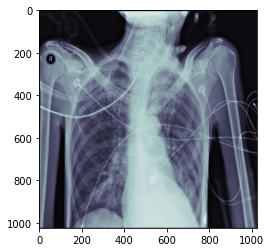

In [18]:
#Plotting a random X-Ray image for visualization
path_eg = capstone_shared_folder_path + r"raw_data/stage_2_train_images/fffec09e-8a4a-48b1-b33e-ab4890ccd136.dcm"
xray_eg = pydicom.dcmread(path_eg)
plt.imshow(xray_eg.pixel_array, cmap=plt.cm.bone) 

In [19]:
#Getting to know how dicom image data is stored for a random image
xray_eg

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.8203.1517874336.95544
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.8203.1517874336.95544
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time          

WE analysed what a diacom image is,  the main attributes from the above meta file and have added the details in our Report

In [20]:
len(xray_eg)  #Number of key-value pairs in the dicom file

35

In [21]:
#Visualizing how the pixel data looks like
xray_eg.PixelData[:10]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff'

In [22]:
xray_eg.pixel_array, xray_eg.pixel_array.shape  #Visualizing image array and its shape

(array([[  0,   0,   1, ...,   0,   0,   0],
        [  3,   0,   0, ...,   1,   1,   1],
        [  2,   0,   2, ...,   0,   0,   0],
        ...,
        [  0,  44, 138, ...,  42,  38,  44],
        [  2,  34,  91, ...,  48,  44,  46],
        [  0,   0,   0, ...,   2,   0,   0]], dtype=uint8), (1024, 1024))

In [23]:
print(len(xray_eg.pixel_array.flatten()))

1048576


In [24]:
print("Maximum value of the pixels:", xray_eg.pixel_array.max() , "\n"
       "Minimum value of the pixels: ", xray_eg.pixel_array.min())

Maximum value of the pixels: 255 
Minimum value of the pixels:  0


In [25]:
patient_sex_eg = xray_eg.data_element("PatientSex") 
patient_age_eg = xray_eg.data_element("PatientAge") 
patient_name_eg = xray_eg.data_element("PatientName")
print("Patient's name/ID :", patient_name_eg.value,"\n"
      "Age:",  patient_age_eg.value ,"\n"
      "Sex :",  patient_sex_eg.value )

Patient's name/ID : fffec09e-8a4a-48b1-b33e-ab4890ccd136 
Age: 45 
Sex : M


# **EDA & VISUALIZATION**

(array([193970.,  45490., 100758., 128708., 147532., 139413., 120967.,
        100748.,  70243.,    747.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

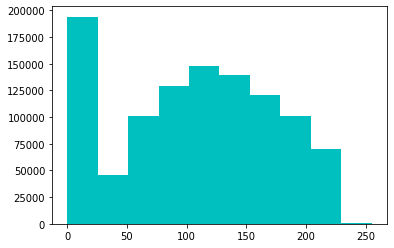

In [26]:
#Visualizing pixel intensity distributions on a histogram

plt.hist(xray_eg.pixel_array.flatten(), color='c')

<font color=darkblue>
The histogram shows that the minimal pixel value is 0 and the maximum pixel value is 255. The histogram is predominantly uni-modal with the majority of pixels between the 0 and 25 pixels and next between 100 and 125 pixels.

Making a data frame containing:

Patient ID, age, sex, imagedata, x, y w, h, labels as columns

In [27]:
df1 = pd.read_csv(capstone_shared_folder_path+"raw_data/stage_2_train_labels.csv/stage_2_train_labels.csv")

In [28]:
df1.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [29]:
df1.shape

(30227, 6)

In [30]:
df2 = pd.read_csv(capstone_shared_folder_path+"raw_data/stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv")

In [31]:
df2.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [32]:
df2.shape

(30227, 2)

In [33]:
df3 =pd.concat([df1, df2['class']], axis = 1)

In [34]:
df3.shape

(30227, 7)

In [35]:
df3

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity


In [36]:
df3[df3.duplicated(['patientId'])].shape  #These duplicates indicate patients that have multiple bounding boxdes

(3543, 7)

In [37]:
len(df1['patientId'].unique())

26684

In [38]:
data_frequency = df3['patientId'].value_counts().reset_index()
data_frequency = data_frequency.sort_values(by='patientId', ascending=False)
data_frequency

,index,patientId
0,3239951b-6211-4290-b237-3d9ad17176db,4
7,32408669-c137-4e8d-bd62-fe8345b40e73,4
12,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,4
11,ee820aa5-4804-4984-97b3-f0a71d69702f,4
10,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,4
...,...,...
11157,f1d94ffb-f4ee-4e30-a376-90c51b843f90,1
11156,f8f84dd5-5c41-4f63-9d3b-23e6e04d7fe8,1
11155,f1d1ceac-9e6d-4ca8-b0da-f918df585511,1
11154,f1dfb6c6-9b3c-490c-b525-9c2c51252c6e,1


In [59]:
%cd '/content/drive/MyDrive/Capstone_CV_Project/'

/content/drive/.shortcut-targets-by-id/19YhQZjFpRth4wLguvjLLzxep29Dos8O5/Capstone_CV_Project


In [61]:
train_folder_name:str = 'stage_2_train_images'
test_folder_name:str = 'stage_2_test_images' 
train_folder_path:str = os.path.join(
                                     'raw_data',
                                     train_folder_name)
test_folder_path:str = os.path.join(
                                    'raw_data',
                                    test_folder_name)

In [64]:
list_train_file_names:list = list(os.listdir(train_folder_path))
list_test_file_names:list = list(os.listdir(test_folder_path))

In [65]:
pat_list:list = []
pat_freq_list = []
image_freq_list = []
for index in range(0,len(data_frequency)):
  pat_id = data_frequency.iloc[index]['index']
  pat_freq = data_frequency.iloc[index]['patientId']
  freq_images = len([value for value in list_train_file_names if value[:-4] == pat_id])
  pat_list.append(pat_id)
  pat_freq_list.append(pat_freq)
  image_freq_list.append(freq_images)

records:pd.DataFrame = pd.DataFrame({'patient_id':pat_list,
              'patient_frequency':pat_freq_list,
              'image_frequency':image_freq_list})
records

,patient_id,patient_frequency,image_frequency
0,3239951b-6211-4290-b237-3d9ad17176db,4,1
1,32408669-c137-4e8d-bd62-fe8345b40e73,4,1
2,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,4,1
3,ee820aa5-4804-4984-97b3-f0a71d69702f,4,1
4,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,4,1
...,...,...,...
26679,f1d94ffb-f4ee-4e30-a376-90c51b843f90,1,1
26680,f8f84dd5-5c41-4f63-9d3b-23e6e04d7fe8,1,1
26681,f1d1ceac-9e6d-4ca8-b0da-f918df585511,1,1
26682,f1dfb6c6-9b3c-490c-b525-9c2c51252c6e,1,1


In [66]:
records.sort_values(by='image_frequency', ascending=False)

,patient_id,patient_frequency,image_frequency
0,3239951b-6211-4290-b237-3d9ad17176db,4,1
17928,abd50515-15ea-489a-bdb8-c38dd3ef0b36,1,1
17796,295de041-5711-400a-8241-7d7cf500971e,1,1
17795,a7fb334c-5fa6-460a-8115-294dfc821187,1,1
17794,ac710523-7dfb-4d63-821c-34b2d6ef03d7,1,1
...,...,...,...
8891,582eabe9-86dd-45ea-958c-f53068114db2,1,1
8890,582e641d-ac17-43b5-89a0-453555dd152e,1,1
8889,582dedfc-19d7-446a-acd3-b8a7081ae664,1,1
8888,5828e978-162a-4726-82e3-a057474d6b8a,1,1


<font color=darkblue>
Detailed Class info file has 30227 records in total, out of which:

*   8851 belong to ‘Normal’ Category
*   9555 show ‘Lung Opacity’ which means there are Pneumonia patches detected
*   11821 row don’t show Pneumonia but show some other abnomality in the lungs

Also, there are 3543 duplicate records, they could have different bounding box coordinates but are duplicate for a patinet ID

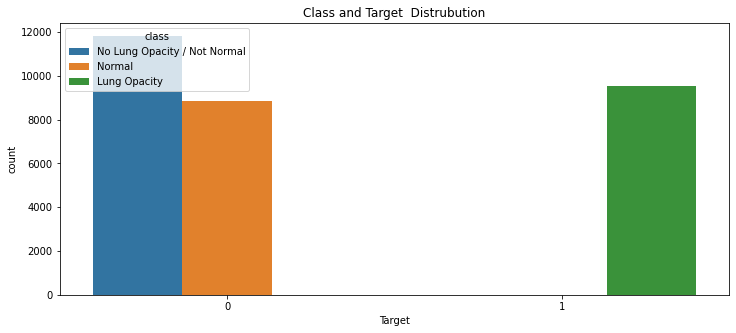

In [67]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5))
graph1 = sns.countplot(x="Target", hue="class", data=df3,ax=ax )
plt.title('Class and Target  Distrubution')

graph1

In [68]:
 directory = r'/content/drive/MyDrive/Capstone_CV_Project/raw_data/stage_2_train_images'

In [69]:
import math

In [70]:
# Analyzing chest X-Ray images with bounding box
import matplotlib.patches as patches

def image_read(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']
        dcm_file = '/content/drive/MyDrive/Capstone_CV_Project/raw_data/stage_2_train_images/'+'{}.dcm'.format(patientImage)
        data_row_img_data = pydicom.read_file(dcm_file)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = pydicom.dcmread(dcm_file)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nBounds: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
        label = data_row["class"]
        if not math.isnan(data_row['x']):
            x, y, width, height  =  data_row['x'],data_row['y'],data_row['width'],data_row['height']
            rect = patches.Rectangle((x, y),width, height,
                                 linewidth = 3,
                                 edgecolor = 'b',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
            ax[i//3, i%3].add_patch(rect)

    plt.show()

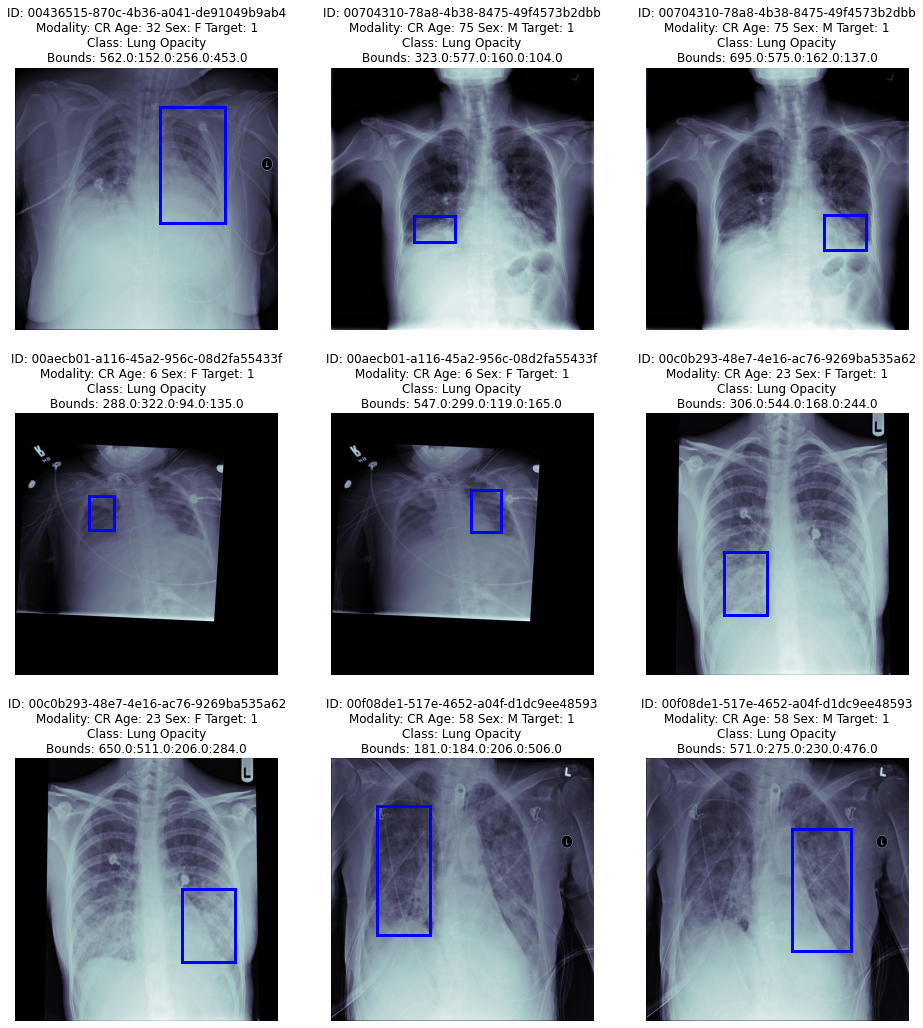

In [71]:
## checking few images which has pneumonia 
image_read(df3[df3['Target']==1].iloc[1:10])

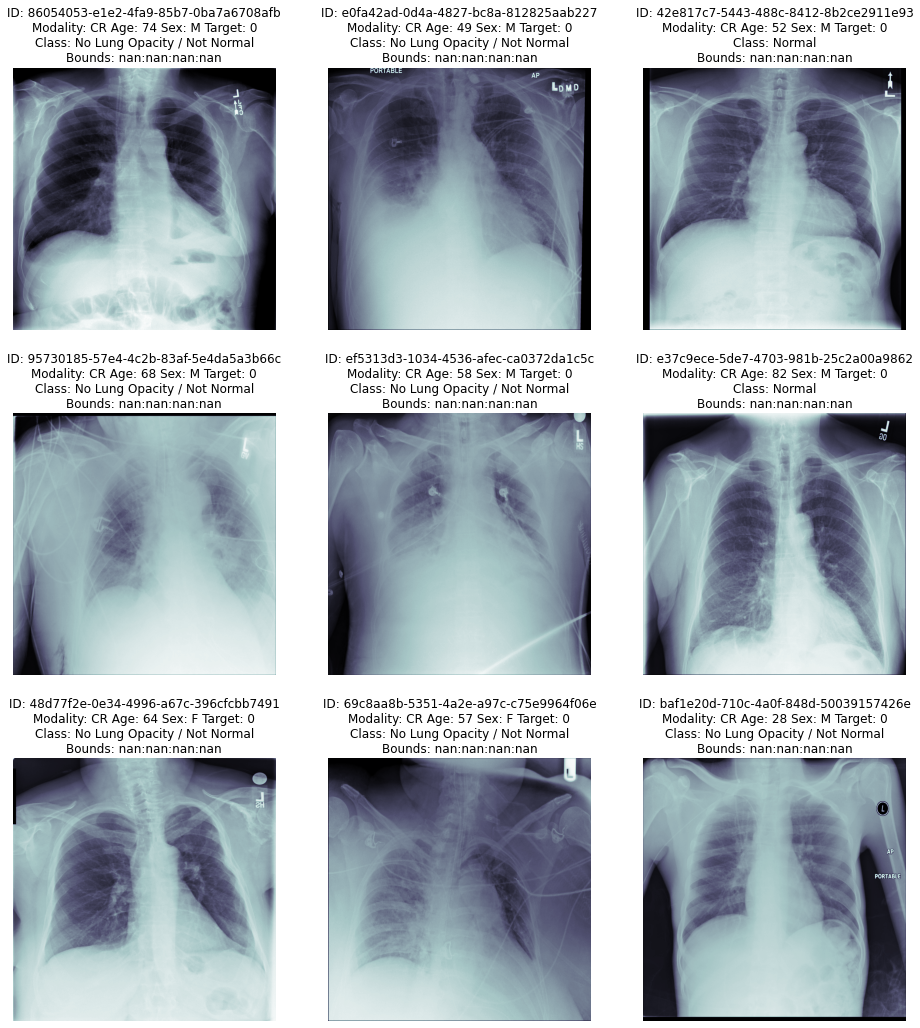

In [72]:
#Visualizing few X-Rays which does not have pneumonia 
image_read(df3[df3['Target']==0].sample(9))

In [73]:
def readDICOM(dicomdata):
    image_path = '/content/drive/MyDrive/Capstone_CV_Project/raw_data/stage_2_train_images/'+'{}.dcm'.format(dicomdata.patientId)
    image_dat = pydicom.read_file(image_path)
    image_array = image_dat.pixel_array
    return image_dat.PatientSex,image_dat.PatientAge

The following step was executed once, as we need to extract the gender and age of each patient. However, this step took 2.5 hours to complete, hence the output of this was saved as csv to be used going forward.

In [74]:
##Reading the xray data and append it to the data frame
#df3['sex'], df3['age'] = zip(*df3.apply(readDICOM, axis=1))
#Runtime is 2.5hrs. so saved as csv

In [75]:
# from google.colab import files
# df3.to_csv('pneumonia_dataset1.csv') 
# files.download('pneumonia_dataset1.csv')

In [79]:
df3=pd.read_csv(capstone_shared_folder_path+"pre_processed_data/pneumonia_dataset1.csv")
df3 = df3.drop(df3.columns[0], axis=1)
df3.head()

,patientId,x,y,width,height,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,51
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,48
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,M,19
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,M,28
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,F,32


As we can see above, we read the saved csv for information on patient gender and age, and appended it to our existing labels dataset.

In [80]:
# We will now make a copy of the consolidated dataframe df3, and drop the bounding box coordinates for now, to do further analysis at the patient ID level
df4= df3.copy(deep=True)

In [81]:
df4.drop(labels=["x","y","width","height"], axis=1, inplace=True, )

In [82]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   Target     30227 non-null  int64 
 2   class      30227 non-null  object
 3   sex        30227 non-null  object
 4   age        30227 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


In [83]:
df4.shape

(30227, 5)

In [84]:
df5 = df4.drop_duplicates(keep='first')


In [85]:
df5.shape

(26684, 5)

In [86]:
df5.head()

,patientId,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,No Lung Opacity / Not Normal,F,51
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0,No Lung Opacity / Not Normal,F,48
2,00322d4d-1c29-4943-afc9-b6754be640eb,0,No Lung Opacity / Not Normal,M,19
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0,Normal,M,28
4,00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity,F,32


In [87]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26684 entries, 0 to 30225
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  26684 non-null  object
 1   Target     26684 non-null  int64 
 2   class      26684 non-null  object
 3   sex        26684 non-null  object
 4   age        26684 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


In [88]:
df3['age'] = df3.age.astype(int)
df5['age'] = df5.age.astype(int)

In [89]:
df5.describe(include="all")

,patientId,Target,class,sex,age
count,26684,26684.000000,26684,26684,26684.000000
unique,26684,NaN,3,2,NaN
top,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,No Lung Opacity / Not Normal,M,NaN
freq,1,NaN,11821,15166,NaN
mean,NaN,0.225304,NaN,NaN,47.030018
std,NaN,0.417790,NaN,NaN,16.810578
min,NaN,0.000000,NaN,NaN,1.000000
25%,NaN,0.000000,NaN,NaN,34.000000
50%,NaN,0.000000,NaN,NaN,49.000000
75%,NaN,0.000000,NaN,NaN,59.000000


In [90]:
df5['sex'].value_counts()

M    15166
F    11518
Name: sex, dtype: int64

In [91]:
df3.isnull().sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
sex              0
age              0
dtype: int64

In [112]:
def get_dicom_info()->pd.DataFrame:
  #train_pixels:list = []
  patient_ids_list:list = []
  labels:list = []
  label_encoded:list = []
  gender:list = []
  age:list = []
  view_position:list = []
  modality:list = []
  # x_coordinate_values:list = []
  # y_coordinate_values:list = []
  # width_coordinate_values:list = []
  # height_coordinate_values:list = []
  coordinates_list = []
  rows_list = []
  columns_list = []
  count:int = 0
  buffer:int = 1
  #iterating through the files on the training folder
  for file_name in list_train_file_names:
    path_image:str = os.path.join(train_folder_path,file_name)
    #reading the dicom image!!
    dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_image)
    #extracting the information from labes files for the following image!!
    filtered_labels:pd.DataFrame = df3[df3['patientId'] == dicom_obj.PatientID]
    #extracting the patient ids
    patient_ids_list.append(dicom_obj.PatientID)
    #extracting the encoded value of the target varaible
    label_encoded.append(
        int(filtered_labels['Target'].iloc[0])
    )
    #extracting the actual class name
    labels.append(
        filtered_labels['class'].iloc[0]
    )
    #extracting the coordinates
    #if we have more the one coordinates for image.
    if filtered_labels.shape[0] > 1:
      buffer_list:list = []
      filtered_labels:pd.DataFrame = filtered_labels.drop_duplicates()
      for index in range(0,filtered_labels.shape[0]):
        buffer_list.append([
            filtered_labels.iloc[index]['x'],
            filtered_labels.iloc[index]['y'],
            filtered_labels.iloc[0]['width'],
            filtered_labels.iloc[0]['height']
        ])
      coordinates_list.append(buffer_list)
    #if we got only one bounding box in the image!!
    else:
      coordinates_list.append(
          [
           filtered_labels.iloc[0]['x'],
           filtered_labels.iloc[0]['y'],
           filtered_labels.iloc[0]['width'],
           filtered_labels.iloc[0]['height']
          ]
      )
    # x_coordinate_values.append(
    #     filtered_labels['x'].iloc[0]
    # )
    # y_coordinate_values.append(
    #     filtered_labels['y'].iloc[0]
    # )
    # width_coordinate_values.append(
    #     filtered_labels['width'].iloc[0]
    # )
    # height_coordinate_values.append(
    #     filtered_labels['height'].iloc[0]
    # )
    gender.append(dicom_obj.PatientSex)
    
    #extracting age from dicom header 
    age.append(dicom_obj.PatientAge)
    #extracting view position from dicom header
    view_position.append(dicom_obj.ViewPosition)
    #extracting modality from dicom header
    modality.append(dicom_obj.Modality)
    #extracting number of rows from dicom header
    rows_list.append(dicom_obj.Rows)
    #extracting number of columns from dicom header
    columns_list.append(dicom_obj.Columns)
    #train_pixels.append(dicom_obj.pixel_array)
    count+=1
    percentage = int((count/len(list_train_file_names))*100)
    if percentage >= buffer:
      print(f'--------{percentage}% images information retrived from {len(list_train_file_names)} images----------')
      buffer+=1

  info_dicom_header:pd.DataFrame = pd.DataFrame({'Patient_ids':patient_ids_list,
              'Class':labels,
              'Encoded_class':label_encoded,
              'Gender':gender,
              'Age':age,
              'View_position':view_position,
              'Modality':modality,
              'coordinates':coordinates_list,
              'No_rows':rows_list,
              'No_columns':columns_list})
  #train_pixels:np.array = np.array(train_pixels)
  return info_dicom_header

In [110]:
%cd '/content/drive/MyDrive/Capstone_CV_Project/'

/content/drive/.shortcut-targets-by-id/19YhQZjFpRth4wLguvjLLzxep29Dos8O5/Capstone_CV_Project


In [116]:
# coordinates_info = get_dicom_info()
# process_storage_folder_path:str = os.path.join(os.getcwd(),'pre_processed_data_set') 
# saved_file_name_coordinates:str = os.path.join(process_storage_folder_path, "coordinates_org.pkl")


In [118]:
# process_storage_folder_path:str = os.path.join(os.getcwd(),'pre_processed_data_set') 
# saved_file_name_coordinates:str = os.path.join(process_storage_folder_path, "coordinates_org.pkl")
coordinates_info:pd.DataFrame = pd.read_pickle('/content/drive/MyDrive/Capstone_CV_Project/pre_processed_data/coordinates_org.pkl')
coordinates_info

,Patient_ids,Class,Encoded_class,Gender,Age,View_position,Modality,coordinates,No_rows,No_columns
0,f74e692e-1ccd-4f5e-bc19-482325025a41,Normal,0,F,62,AP,CR,"[nan, nan, nan, nan]",1024,1024
1,f7909c0c-c9f0-4c93-be7f-113926850ac3,No Lung Opacity / Not Normal,0,F,81,AP,CR,"[nan, nan, nan, nan]",1024,1024
2,f758a20a-506d-4e4e-97d7-54043148fb59,Normal,0,M,45,PA,CR,"[nan, nan, nan, nan]",1024,1024
3,f78a62d0-f9aa-4828-ad8c-ec4917f52d48,Lung Opacity,1,F,66,AP,CR,"[181.0, 695.0, 195.0, 187.0]",1024,1024
4,f7a5fd29-dd8d-4f85-8164-69b2e83da35e,Normal,0,M,50,PA,CR,"[nan, nan, nan, nan]",1024,1024
...,...,...,...,...,...,...,...,...,...,...
26679,0986f27b-74ed-4bc7-9595-e40b345cb161,No Lung Opacity / Not Normal,0,M,52,AP,CR,"[nan, nan, nan, nan]",1024,1024
26680,094eed38-9c5b-4042-936d-344ccec4c3cc,Lung Opacity,1,F,65,AP,CR,"[[122.0, 350.0, 300.0, 450.0], [544.0, 346.0, ...",1024,1024
26681,0983ae59-b906-4fd5-a810-edfe0580fe3b,Lung Opacity,1,M,59,PA,CR,"[212.0, 333.0, 224.0, 391.0]",1024,1024
26682,098fdba1-4918-40e8-bb74-9945214c8bd5,Normal,0,F,45,AP,CR,"[nan, nan, nan, nan]",1024,1024


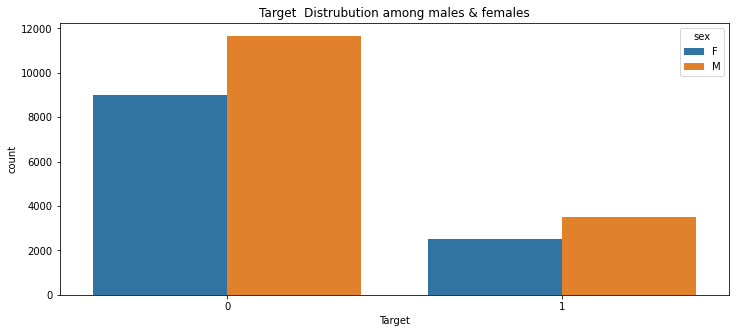

In [92]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5))
graph2 = sns.countplot(x="Target", hue="sex", data=df5,ax=ax )
plt.title('Target  Distrubution among males & females')

graph2

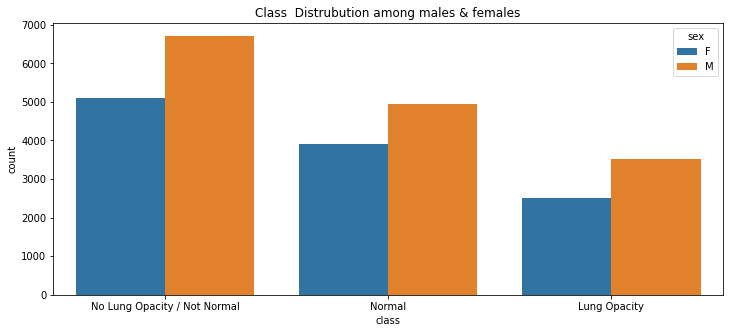

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5))
graph3 = sns.countplot(x="class", hue="sex", data=df5,ax=ax )
plt.title('Class  Distrubution among males & females')

graph3


*   <font color=darkblue>
&nbsp;The number of males with Pneumonia is higher than females
*   <font color=darkblue>
&nbsp;In all three categories of classes males are more than females






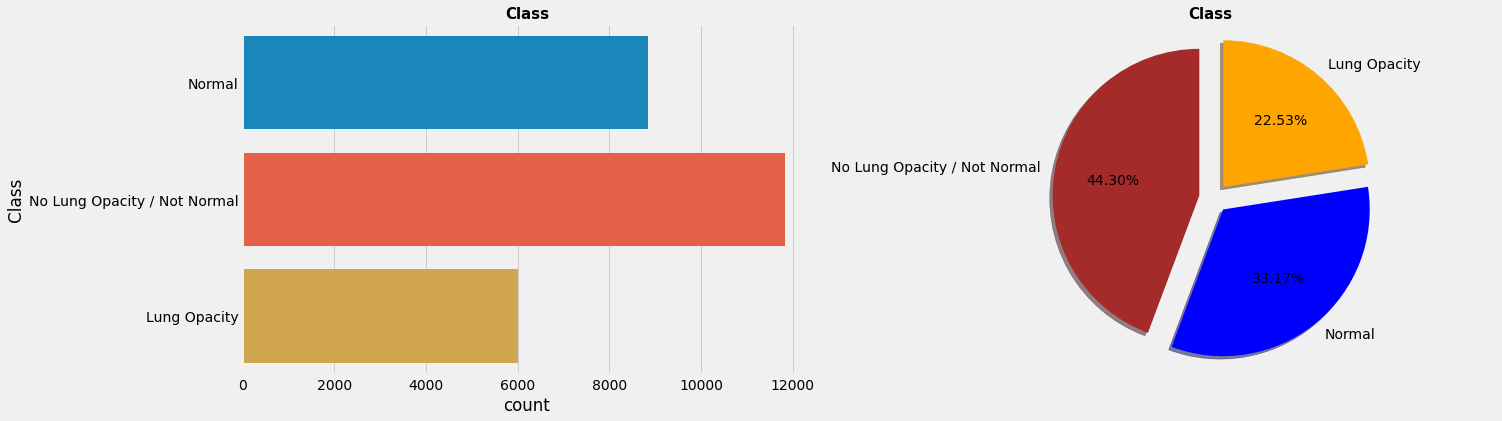

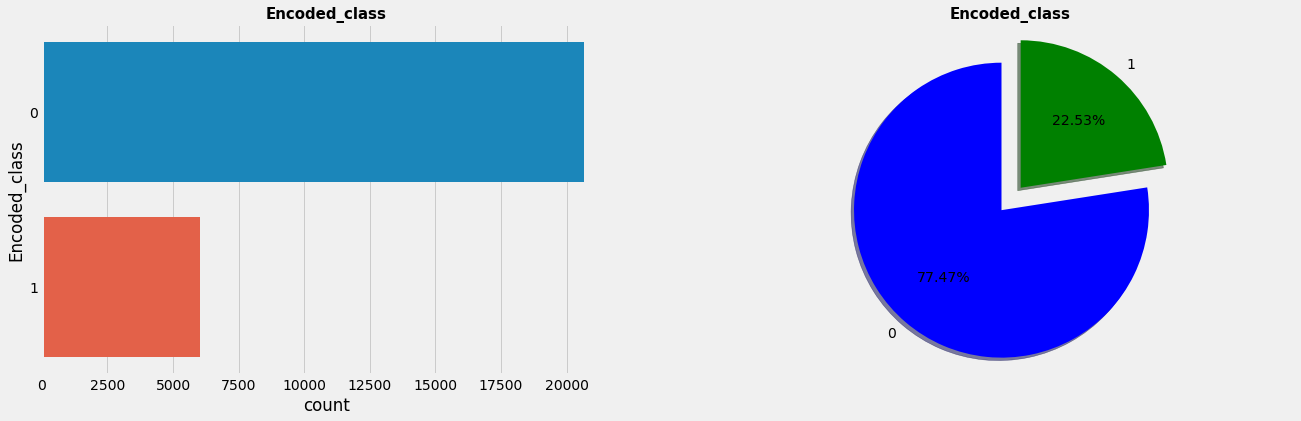

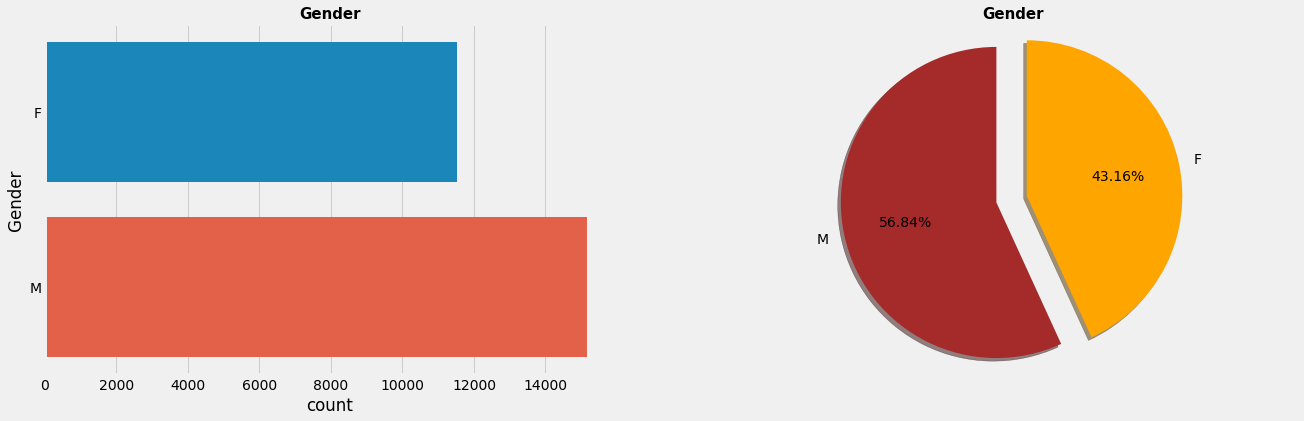

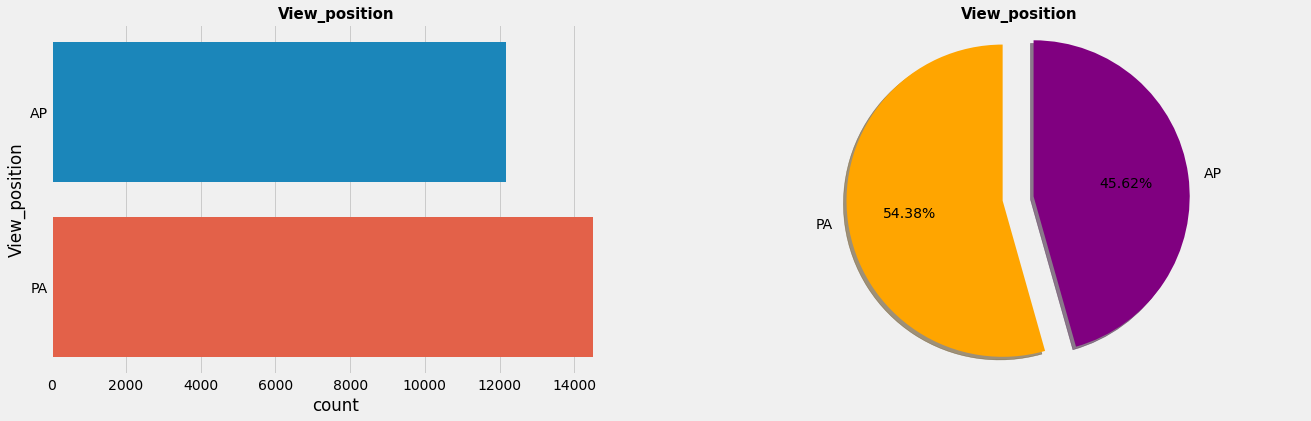

In [120]:
categorical_column_names = ['Class',
                            'Encoded_class',
                            'Gender',
                            'View_position']
for category_variable in categorical_column_names:
    #fig 1
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(20,6))
    plt.subplot(1, 2, 1)
    plt.title(category_variable,fontweight="bold",fontsize=15)
    sns.countplot(y=category_variable, data=coordinates_info)

    plt.subplot(1, 2, 2)
    plt.title(category_variable,fontweight="bold",fontsize=15)
    explode = []
    colors = []
    for ex in coordinates_info[category_variable].unique():
        explode.append(0.1)
        colors.append(np.random.choice(all_colors))
    plt.pie(coordinates_info[category_variable].value_counts().reset_index()[category_variable],labels=coordinates_info[category_variable].value_counts().reset_index()['index'], colors=colors, startangle=90, shadow=True,explode=tuple(explode), autopct='%1.2f%%')
    plt.axis('equal')
plt.show()

we can infer from the above visulation,

Encoded_class :- We have class imbalance problem in our dataset, where we have only 22% of patients who got effected by pneumonia

we can also see from the view position that we got two different view points of medical images.

AP - erect anteroposterior chest view is an alternative to the PA view when the patient is too unwell to tolerate standing or leaving the bed

PA - Chest Posterior Anterior

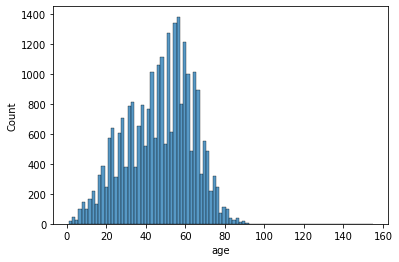

In [ ]:
sns.histplot(df5.age,"on") 

In [121]:
coordinates_info.groupby(['View_position']).count()/len(coordinates_info)

,Patient_ids,Class,Encoded_class,Gender,Age,Modality,coordinates,No_rows,No_columns
View_position,,,,,,,,,
AP,0.456191,0.456191,0.456191,0.456191,0.456191,0.456191,0.456191,0.456191,0.456191
PA,0.543809,0.543809,0.543809,0.543809,0.543809,0.543809,0.543809,0.543809,0.543809


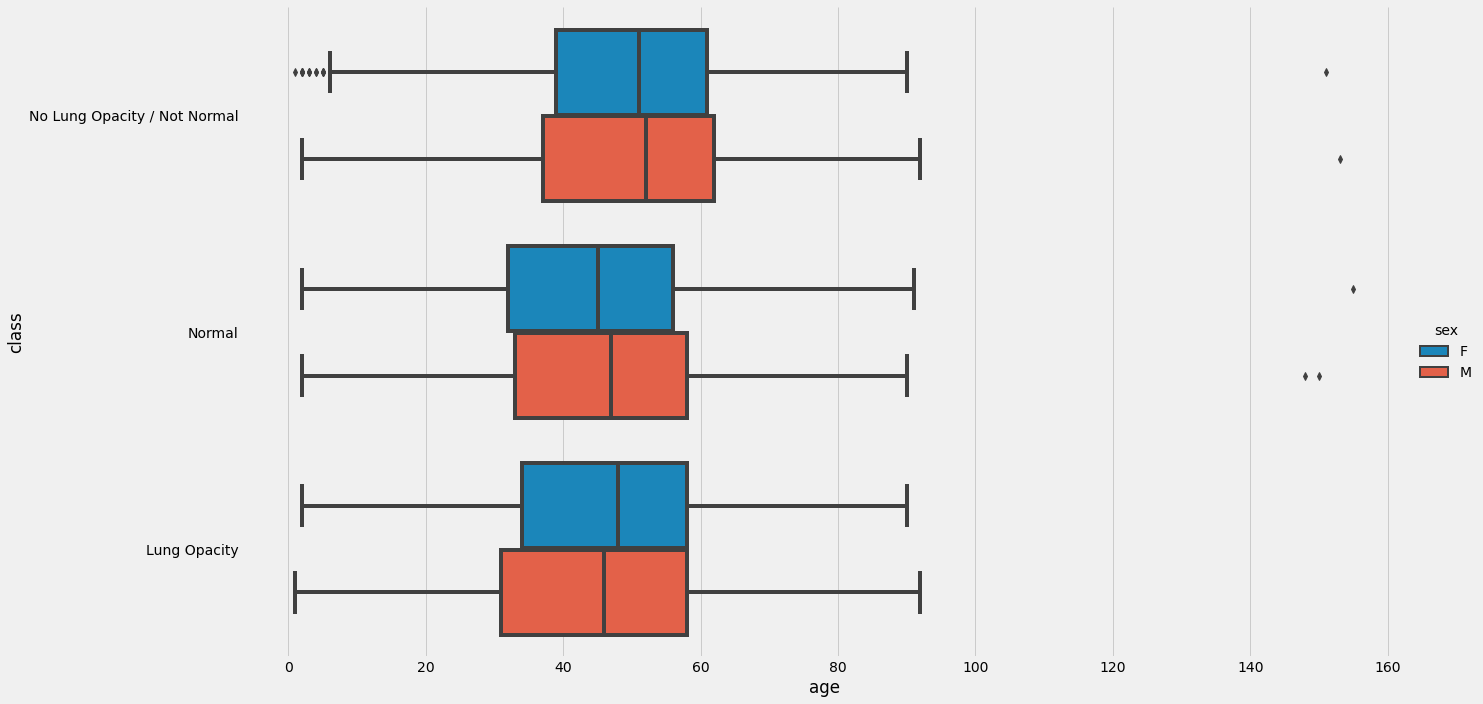

In [131]:

sns.catplot(x="age", y="class", kind="box",hue="sex", data=df3,orient="h",height=10, aspect=2)

In [133]:
filtered_ap_data:pd.DataFrame = coordinates_info.loc[(coordinates_info.View_position == 'AP') & (coordinates_info.Encoded_class == 1)]
filtered_ap_data.head(2)
# Images which contain Lung Opacity
# viewing AP view



,Patient_ids,Class,Encoded_class,Gender,Age,View_position,Modality,coordinates,No_rows,No_columns
3,f78a62d0-f9aa-4828-ad8c-ec4917f52d48,Lung Opacity,1,F,66,AP,CR,"[181.0, 695.0, 195.0, 187.0]",1024,1024
8,f7a42b73-f909-4e1f-89dd-c776f45cdc40,Lung Opacity,1,M,34,AP,CR,"[[638.0, 367.0, 250.0, 519.0], [178.0, 341.0, ...",1024,1024


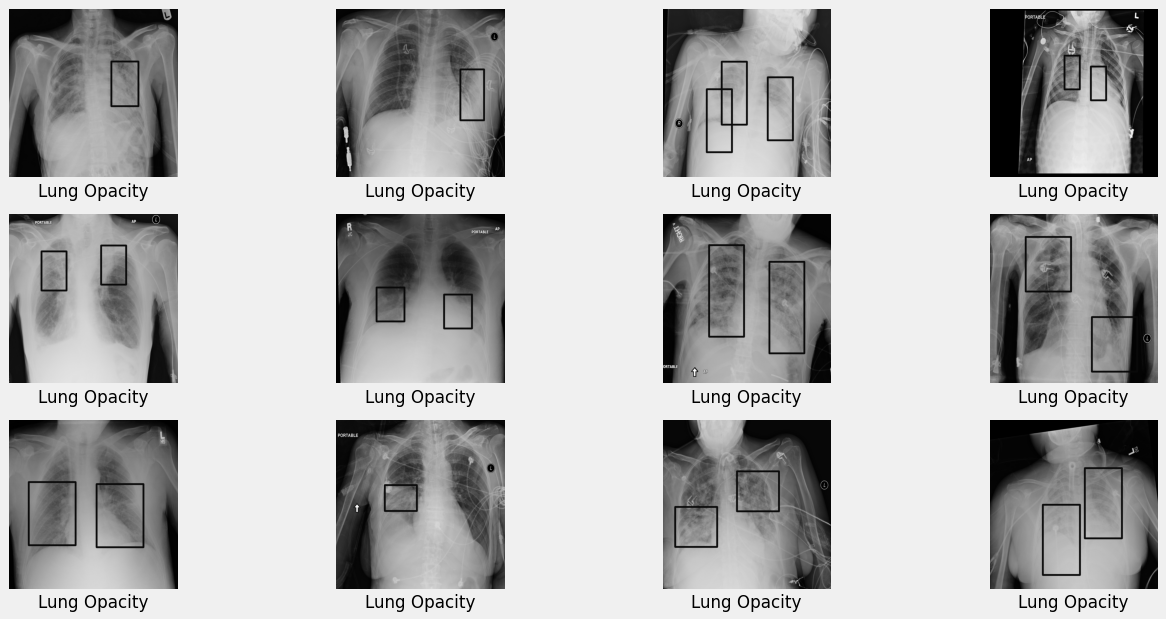

In [134]:
#Multiple bounding box lung images

no_images:int = 12
rows_to_display:list = random.sample(list(filtered_ap_data.index), no_images)
random.seed(13)
plt.figure(figsize=(20,10))
num:int = 0
for index_number in rows_to_display:
  num+=1
  plt.subplot(3,4,num)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  path_image:str = os.path.join(train_folder_path,
                                filtered_ap_data.loc[index_number].Patient_ids+'.dcm')
  dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_image)
  pixel_values:np.array = dicom_obj.pixel_array
  if type(filtered_ap_data.loc[index_number].coordinates[0]) == list:
    for coordinate in filtered_ap_data.loc[index_number].coordinates:
      cv2.rectangle(pixel_values, (int(coordinate[0]),
                                   int(coordinate[1])),
                     (int(coordinate[0])+int(coordinate[2]),
                      int(coordinate[1])+int(coordinate[3])), (10, 255, 0), 10)
  else:
    coordinate:list = filtered_ap_data.loc[index_number].coordinates
    cv2.rectangle(pixel_values, (int(coordinate[0]),
                                 int(coordinate[1])),
                   (int(coordinate[0])+int(coordinate[2]), int(coordinate[1])+int(coordinate[3])), (10, 255, 0), 10)
  plt.imshow(cv2.cvtColor(pixel_values, cv2.COLOR_BGR2RGB),cmap="gray")
  plt.xlabel(filtered_ap_data.loc[index_number].Class)
plt.show()

In [135]:
#viewing PA view
filtered_pa_data:pd.DataFrame = coordinates_info.loc[(coordinates_info.View_position == 'PA') & (coordinates_info.Encoded_class == 1)]
filtered_pa_data.head(2)


,Patient_ids,Class,Encoded_class,Gender,Age,View_position,Modality,coordinates,No_rows,No_columns
27,f7f3e746-b2d6-47e8-87fd-e7d9db9b1836,Lung Opacity,1,M,71,PA,CR,"[139.0, 506.0, 298.0, 227.0]",1024,1024
81,f87e319e-34e7-4d47-893f-8a004ffcb94f,Lung Opacity,1,F,32,PA,CR,"[125.0, 258.0, 261.0, 365.0]",1024,1024


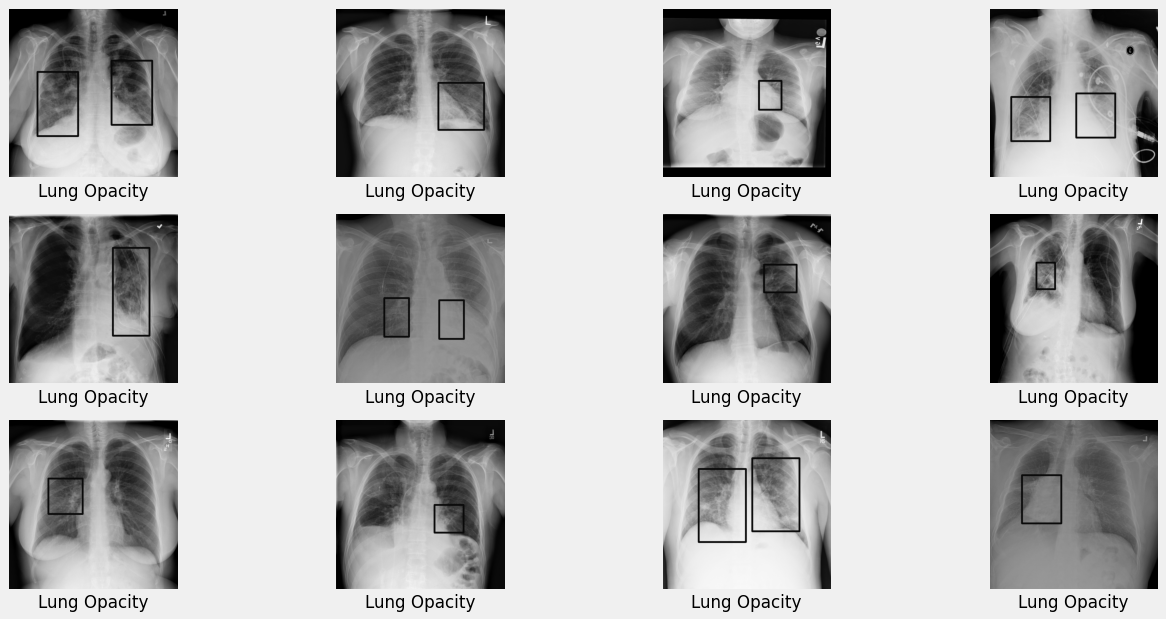

In [136]:
no_images:int = 12
rows_to_display:list = random.sample(list(filtered_pa_data.index), no_images)
random.seed(13)
plt.figure(figsize=(20,10))
num:int = 0
for index_number in rows_to_display:
  num = num+1
  plt.subplot(3,4,num)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  path_image:str = os.path.join(train_folder_path,
                                filtered_pa_data.loc[index_number].Patient_ids+'.dcm')
  dicom_obj:pydicom.dataset.FileDataset = pydicom.read_file(path_image)
  pixel_values:np.array = dicom_obj.pixel_array
  if type(filtered_pa_data.loc[index_number].coordinates[0]) == list:
    for coordinate in filtered_pa_data.loc[index_number].coordinates:
      cv2.rectangle(pixel_values, (int(coordinate[0]),
                                   int(coordinate[1])),
                     (int(coordinate[0])+int(coordinate[2]),
                      int(coordinate[1])+int(coordinate[3])), (10, 255, 0), 10)
  else:
    coordinate:list = filtered_pa_data.loc[index_number].coordinates
    cv2.rectangle(pixel_values, (int(coordinate[0]),
                                 int(coordinate[1])),
                   (int(coordinate[0])+int(coordinate[2]), int(coordinate[1])+int(coordinate[3])), (10, 255, 0), 10)
  plt.imshow(cv2.cvtColor(pixel_values, cv2.COLOR_BGR2RGB),cmap="gray")
  plt.xlabel(filtered_pa_data.loc[index_number].Class)
plt.show()

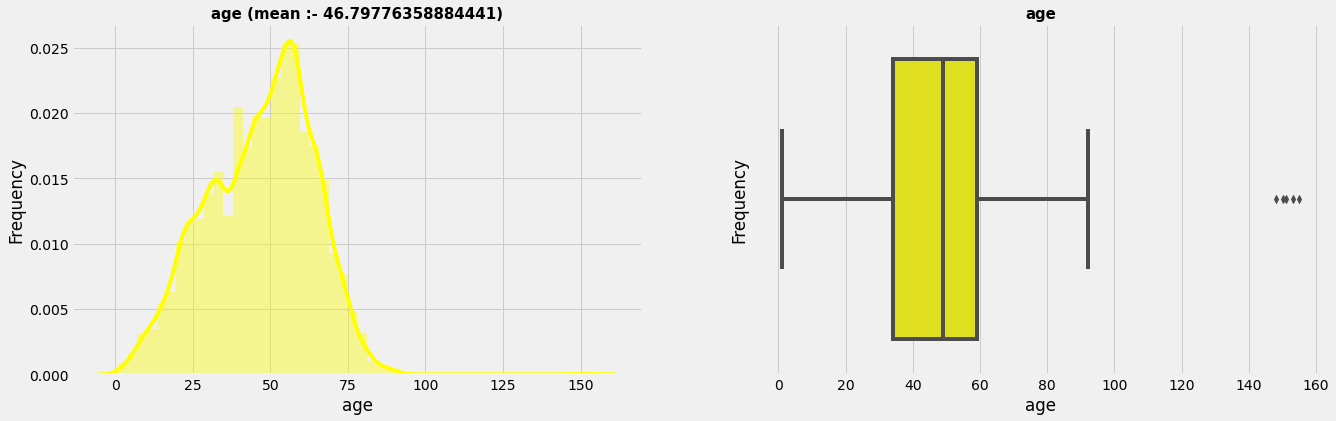

In [100]:
import warnings
warnings.filterwarnings("ignore")
all_colors: list = [
    "blue",
    "green",
    "yellow",
    "pink",
    "orange",
    "purple",
    "brown",
    "red",
]
col = np.random.choice(all_colors)
# variable 1
plt.style.use("fivethirtyeight")
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('age (mean :- '+str(coordinates_info['age'].mean())+')', fontweight="bold", fontsize=15)
plt.ylabel("Frequency")
sns.distplot(coordinates_info['age'], color=col)

plt.subplot(1, 2, 2)
plt.title('age', fontweight="bold", fontsize=15)
plt.ylabel("Frequency")
sns.boxplot(coordinates_info['age'], orient="vertical", color=col)
plt.show()


<font color=darkblue>
&nbsp;
Age distribution is normal


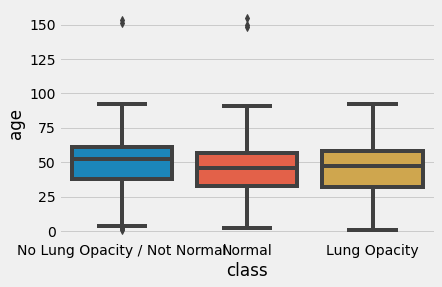

In [137]:
sns.boxplot(x='class', y='age', data = df5)

<font color=darkblue>
&nbsp;
Outliers in normal and not normal classes are unusual as these are in the range of 140 to 160. This might be due to the possible wrong entries. However, this will not effect the model training on images as model will be trained taking into consideration only the dicom image pixel data for classification purpose and detection which is the scope of this project objective.

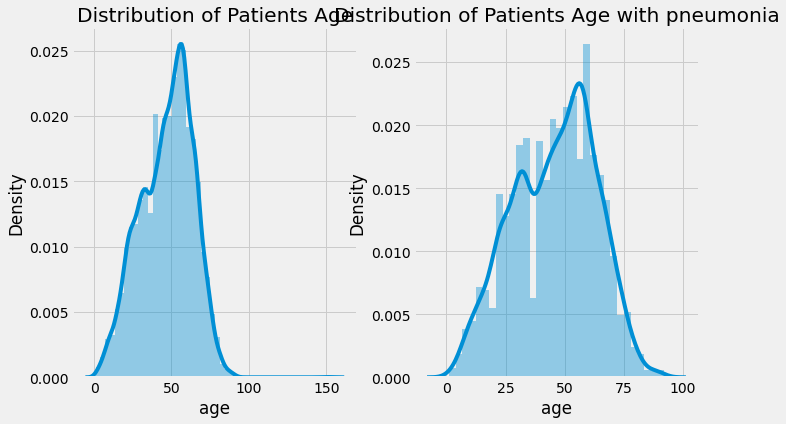

In [138]:
# Now lets compare the age distribution in our complete sample with age distribution in patients with pneumonia 
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(df5['age']).set_title('Distribution of Patients Age'))

ax = fig.add_subplot(122)
g = (sns.distplot(df5.loc[df5['Target'] == 1, 'age']).set_title('Distribution of Patients Age with pneumonia'))






*   <font color=darkblue>
&nbsp;Pneumonia patients age distribution is left-skewed with most of the age group around 60
*   <font color=darkblue>
&nbsp;Normal patients age is distributed normally



In [139]:
print(df3[(df3['Target']==0)==True].count())

patientId    20672
x                0
y                0
width            0
height           0
Target       20672
class        20672
sex          20672
age          20672
dtype: int64


In [140]:
df6=df3.copy(deep=True)

In [141]:
df6

,patientId,x,y,width,height,Target,class,sex,age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,51
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,F,48
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,M,19
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,M,28
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,F,32
...,...,...,...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,M,54
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0,Normal,F,46
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal,M,45
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,F,72


In [142]:
# Getting rows of PAtients (including duplicate rows (multiple patches) with Pneumonia as True)
df6 = df6[df6.Target == 1]

In [143]:
df6

,patientId,x,y,width,height,Target,class,sex,age
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,F,32
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,F,32
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,M,75
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,M,75
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,Lung Opacity,F,6
...,...,...,...,...,...,...,...,...,...
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1,Lung Opacity,F,47
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1,Lung Opacity,M,54
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,M,54
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,F,72


In [144]:
# Getting actual number of Patients who have pneumonia, here we will discard duplicates and get one row per patient
# df5 = had one record per patient with target, class , sex and age attributes.
df7 = df5[df5.Target == 1]

In [145]:
df7

,patientId,Target,class,sex,age
4,00436515-870c-4b36-a041-de91049b9ab4,1,Lung Opacity,F,32
8,00704310-78a8-4b38-8475-49f4573b2dbb,1,Lung Opacity,M,75
14,00aecb01-a116-45a2-956c-08d2fa55433f,1,Lung Opacity,F,6
16,00c0b293-48e7-4e16-ac76-9269ba535a62,1,Lung Opacity,F,23
19,00f08de1-517e-4652-a04f-d1dc9ee48593,1,Lung Opacity,M,58
...,...,...,...,...,...
30208,c18d1138-ba74-4af5-af21-bdd4d2c96bb5,1,Lung Opacity,F,63
30214,c1cddf32-b957-4753-acaa-472ab1447e86,1,Lung Opacity,M,49
30219,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,1,Lung Opacity,F,47
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,1,Lung Opacity,M,54


So there are 6012 patients who have Pneumonia and a total of 9555 pneumonia patches

In [146]:
df6

,patientId,x,y,width,height,Target,class,sex,age
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,F,32
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,F,32
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,M,75
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,M,75
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,Lung Opacity,F,6
...,...,...,...,...,...,...,...,...,...
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1,Lung Opacity,F,47
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1,Lung Opacity,M,54
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1,Lung Opacity,M,54
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity,F,72


In [147]:
# Lets analyse how many patients have a single patch, and how many have more than 1. df6 data frame has all the rows with target = 1, so each row represents one pneumonia patch
box_df = df6.groupby('patientId').\
    size().\
    reset_index(name='boxes')
comb_box_df = pd.merge(df5, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

,boxes,patients
0,1,2614
1,2,3266
2,3,119
3,4,13


So now we will convert the bounding box coordinates in the form of a dictionary to make it usable by our downstream models

In [148]:
import csv
bboxes = {}
with open(os.path.join(capstone_shared_folder_path +'raw_data/stage_2_train_labels.csv/stage_2_train_labels.csv'), mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None)
    for rows in reader:
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        if pneumonia == '1':
            location = [int(float(i)) for i in location]
            if filename in bboxes:
                bboxes[filename].append(location)
            else:
                bboxes[filename] = [location]

In [ ]:
bboxes["24dba8ea-22b9-4a3c-84ce-6bafeab8e6d1"]

[[652, 503, 83, 147], [373, 572, 98, 57]]

In [149]:
bboxes.values()

dict_values([[[264, 152, 213, 379], [562, 152, 256, 453]], [[323, 577, 160, 104], [695, 575, 162, 137]], [[288, 322, 94, 135], [547, 299, 119, 165]], [[306, 544, 168, 244], [650, 511, 206, 284]], [[181, 184, 206, 506], [571, 275, 230, 476]], [[703, 416, 84, 77]], [[652, 437, 161, 293], [301, 405, 141, 279]], [[133, 613, 275, 275], [678, 427, 224, 340]], [[155, 182, 273, 501], [599, 220, 227, 508]], [[229, 318, 250, 301], [604, 216, 196, 328]], [[141, 306, 225, 327], [609, 285, 236, 355]], [[214, 582, 239, 133], [664, 540, 223, 203]], [[225, 415, 98, 101]], [[366, 289, 208, 527], [714, 278, 255, 576]], [[535, 626, 177, 240], [175, 825, 168, 109]], [[218, 667, 258, 324], [756, 556, 225, 441]], [[664, 380, 141, 330]], [[222, 258, 194, 436], [570, 268, 249, 453]], [[368, 677, 101, 139]], [[676, 292, 163, 186], [301, 354, 172, 393]], [[602, 438, 101, 101], [364, 419, 96, 121]], [[319, 437, 170, 289], [669, 449, 162, 284]], [[647, 403, 242, 386], [193, 360, 203, 429]], [[283, 453, 157, 273],

In [153]:
# coordinates_info = get_dicom_info()
# process_storage_folder_path:str = os.path.join(os.getcwd(),'pre_processed_data_set') 
# saved_file_name_coordinates:str = os.path.join(process_storage_folder_path, "coordinates_org.pkl")